# Perform Random Forest Analysis on acoustic measures

Input large df with acoustic measures for each vowel in each word and output feature importance.

In [1]:
import pandas as pd
import numpy as np
from numpy import mean
from numpy import std
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.colors as mcolors
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold as kfold
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
import matplotlib.cbook as cbook

In [2]:
df = pd.read_csv("data/data_bigPCA.csv")
df.head()

,spec_dur,f0_creak,vowel_periph,Filename,Label,partID,Language,t1_wd,t2_wd,stress
0,-2.082444,1.975650,-0.034866,afs116_catala_exp2_a.mat,i,afs116,cat,5.502012,6.2491,0
1,4.574169,3.367846,0.112931,afs116_catala_exp2_a.mat,a,afs116,cat,5.502012,6.2491,1
2,3.266917,2.909851,1.798889,afs116_catala_exp2_a.mat,i,afs116,cat,10.850600,12.0906,0
3,5.502514,3.287845,0.004191,afs116_catala_exp2_a.mat,a,afs116,cat,10.850600,12.0906,1
4,4.762114,2.906207,1.791195,afs116_catala_exp2_a.mat,i,afs116,cat,40.617489,42.1002,0


In [3]:
df_1 = df[(df['Label']=="i") | (df['Label']=="pen")].copy()
df_2 = df[(df['Label']!="i") & (df['Label']!="pen")].copy()

In [4]:
df_wd = pd.merge(df_1, df_2, on=['Filename', 't1_wd', 't2_wd', 'partID', 'Language'],
                 suffixes=('_vowel1', '_vowel2'))

Label row as `Paroxytone` if vowel 1 is stressed and `Oxytone` if vowel 2 is stressed.

In [5]:
df_wd['stress_wd'] = np.where(df_wd['stress_vowel1']==1, 'Paroxytone', 'Oxytone')

In [6]:
df_wd.columns

Index(['spec_dur_vowel1', 'f0_creak_vowel1', 'vowel_periph_vowel1', 'Filename',
       'Label_vowel1', 'partID', 'Language', 't1_wd', 't2_wd', 'stress_vowel1',
       'spec_dur_vowel2', 'f0_creak_vowel2', 'vowel_periph_vowel2',
       'Label_vowel2', 'stress_vowel2', 'stress_wd'],
      dtype='object')

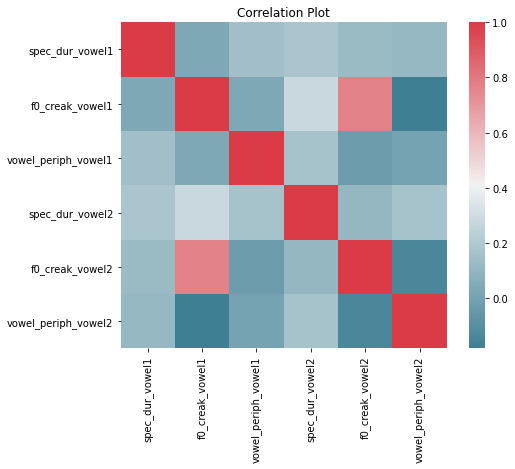

In [7]:
subset = df_wd.drop(['t1_wd', 't2_wd', 'stress_vowel1', 'stress_vowel2'], axis =1)
cor= subset.corr(method='pearson')
fig, ax =plt.subplots(figsize=(8, 6))
plt.title("Correlation Plot")
sns.heatmap(cor, mask=np.zeros_like(cor, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True),
            square=True, ax=ax)
plt.show()

In [8]:
df_wd['f0_creak_ratio'] = df_wd['f0_creak_vowel1']/df_wd['f0_creak_vowel2']

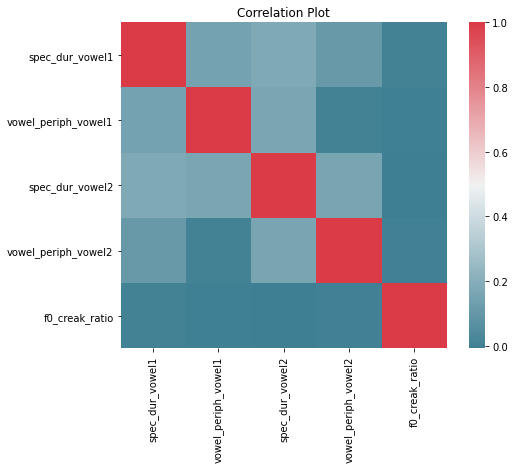

In [9]:
subset = df_wd.drop(['t1_wd', 't2_wd', 'stress_vowel1', 'stress_vowel2', 'f0_creak_vowel1', 'f0_creak_vowel2'],
                    axis = 1)
cor= subset.corr(method='pearson')
fig, ax =plt.subplots(figsize=(8, 6))
plt.title("Correlation Plot")
sns.heatmap(cor, mask=np.zeros_like(cor, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True),
            square=True, ax=ax)
plt.show()

New column for vowel duration ratio, new column for syllable duration ratio, new column for Delta F distance from center calculation, new column for energy ratio.

In [10]:
df_wd.columns

Index(['spec_dur_vowel1', 'f0_creak_vowel1', 'vowel_periph_vowel1', 'Filename',
       'Label_vowel1', 'partID', 'Language', 't1_wd', 't2_wd', 'stress_vowel1',
       'spec_dur_vowel2', 'f0_creak_vowel2', 'vowel_periph_vowel2',
       'Label_vowel2', 'stress_vowel2', 'stress_wd', 'f0_creak_ratio'],
      dtype='object')

In [11]:
df_wd.drop(['Filename', 't1_wd', 't2_wd', 'Label_vowel1', 'Label_vowel2', 'stress_vowel1', 'stress_vowel2',
           'f0_creak_vowel1', 'f0_creak_vowel2'], axis = 1,
          inplace = True)
df_wd.columns

Index(['spec_dur_vowel1', 'vowel_periph_vowel1', 'partID', 'Language',
       'spec_dur_vowel2', 'vowel_periph_vowel2', 'stress_wd',
       'f0_creak_ratio'],
      dtype='object')

Look for empty rows

In [12]:
df_wd.isnull().sum()

spec_dur_vowel1        0
vowel_periph_vowel1    0
partID                 0
Language               0
spec_dur_vowel2        0
vowel_periph_vowel2    0
stress_wd              0
f0_creak_ratio         0
dtype: int64

In [13]:
y_all = df_wd['stress_wd']
X_all = df_wd.drop(['stress_wd', 'Language', 'partID'], axis = 1)
    
rf_classifier = RandomForestClassifier(random_state = 10)
    
param_grid = { 
    'n_estimators': [500],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : np.arange(4,10,1),
    'criterion' :['gini', 'entropy']
}

CV_rfc = GridSearchCV(estimator=rf_classifier, param_grid=param_grid, cv= 5)
CV_rfc.fit(X_all, y_all)
    
print("Best RF Estimator: ", CV_rfc.best_params_, "\n")
    
scores = cross_val_score(rf_classifier, X_all, y_all.ravel(), cv=5)
print("Accuracy over all data: ", scores.mean())
    
rf_classifier_best = CV_rfc.best_estimator_

cols = X_all.columns

Best RF Estimator:  {'criterion': 'entropy', 'max_depth': 9, 'max_features': 'auto', 'n_estimators': 500} 

Accuracy over all data:  0.6931242577631553


In [14]:
def rf(df, rf_classifier_best, cols):
    lang = []
    partid = []
    dfs = []
        
    for p in df.partID.unique():
        data = df[df['partID']==p].copy()
        
        for l in data.Language.unique():
            # isolate language of interest
            data1 = data[data['Language']==l].copy()
            data1.drop(['Language', 'partID'], axis = 1, inplace = True)
            data1.reset_index(inplace = True, drop = True)
            
            # define predictor label
            y = data1['stress_wd']

            # define feature set
            X = data1.drop(['stress_wd'], axis = 1)
            
            rf_classifier_best.fit(X, y.ravel())
            importances = rf_classifier_best.feature_importances_
            std = np.std([tree.feature_importances_ for tree in rf_classifier_best.estimators_], axis=0)
            q_25 = np.percentile([tree.feature_importances_ for tree in rf_classifier_best.estimators_], 25, axis = 0)
            q_75 = np.percentile([tree.feature_importances_ for tree in rf_classifier_best.estimators_], 75, axis = 0)
            
            # make df
            columns = ['Feature', 'Importance (MDI)', 'Std', 'q25', 'q75']
            rfs = pd.DataFrame([cols, importances, std, q_25, q_75]).transpose()
            rfs.columns = columns
            rfs['Language'] = l
            rfs['partID'] = p
            dfs.append(rfs)
        
    rf_df = pd.concat(dfs)
        
    return(rf_df)

In [15]:
rf_df = rf(df_wd, rf_classifier_best, cols)
rf_df.head()

,Feature,Importance (MDI),Std,q25,q75,Language,partID
0,spec_dur_vowel1,0.129326,0.233478,0.0,0.214145,cat,afs116
1,vowel_periph_vowel1,0.205407,0.31475,0.0,0.389581,cat,afs116
2,spec_dur_vowel2,0.333492,0.293597,0.0,0.573557,cat,afs116
3,vowel_periph_vowel2,0.207676,0.268126,0.0,0.391334,cat,afs116
4,f0_creak_ratio,0.124099,0.211043,0.0,0.221721,cat,afs116


Merge in BLP PCA components.

In [16]:
parts = pd.read_csv("../blp/data/parts.csv")
parts['partID'] = parts['partID'].map(str.lower)

In [17]:
rf_lang = pd.merge(rf_df, parts, on = "partID", how = "left")
rf_lang.head()

,Feature,Importance (MDI),Std,q25,q75,Language,partID,lang_profile
0,spec_dur_vowel1,0.129326,0.233478,0.0,0.214145,cat,afs116,l1_eng
1,vowel_periph_vowel1,0.205407,0.31475,0.0,0.389581,cat,afs116,l1_eng
2,spec_dur_vowel2,0.333492,0.293597,0.0,0.573557,cat,afs116,l1_eng
3,vowel_periph_vowel2,0.207676,0.268126,0.0,0.391334,cat,afs116,l1_eng
4,f0_creak_ratio,0.124099,0.211043,0.0,0.221721,cat,afs116,l1_eng


In [18]:
blp_pca = pd.read_csv("../blp/data/pca_blp.csv")
blp_pca.drop(['lang_profile'], axis = 1, inplace = True)

In [19]:
rf_df_blp = pd.merge(rf_lang, blp_pca, on="partID", how = "left")
rf_df_blp.sample(10)

,Feature,Importance (MDI),Std,q25,q75,Language,partID,lang_profile,pc1,pc2
177,spec_dur_vowel2,0.18683,0.112044,0.100259,0.262094,eng,als086,l3_eng,-3.718344,-3.322950
564,f0_creak_ratio,0.155061,0.106286,0.075207,0.230305,eng,rrr070,l3_eng,-3.845810,-0.133834
625,spec_dur_vowel1,0.33717,0.135702,0.248106,0.430919,eng,ael236,mono,NaN,NaN
534,f0_creak_ratio,0.40648,0.174164,0.29779,0.521326,spa,nlc102,l3_eng,-7.496279,2.840882
768,vowel_periph_vowel2,0.297909,0.163329,0.165899,0.417164,cat,lrs017,l3_eng,-5.213138,-0.539701
502,spec_dur_vowel2,0.197356,0.128064,0.094986,0.275819,spa,nde013,l1_eng,2.538150,-2.341168
822,spec_dur_vowel2,0.177789,0.094856,0.107613,0.243824,eng,osl017,mono,NaN,NaN
343,vowel_periph_vowel2,0.177553,0.097068,0.110112,0.236037,eng,enp048,l3_eng,-3.268563,-3.386351
448,vowel_periph_vowel2,0.253551,0.178564,0.119946,0.368872,spa,lld031,l1_eng,8.320398,4.558126
639,f0_creak_ratio,0.183253,0.096362,0.113101,0.241717,eng,anm149,l1_eng,1.556867,0.403033


In [20]:
rf_df_blp['Stdx2'] = rf_df_blp['Std']*2

In [21]:
rf_df_blp.to_csv("data/rf_by_parts_bigPCA_noratio.csv", index = False)

## Visualize across BLP components

In [22]:
df = pd.read_csv("data/rf_by_parts_bigPCA_noratio.csv")
df.head()

,Feature,Importance (MDI),Std,q25,q75,Language,partID,lang_profile,pc1,pc2,Stdx2
0,spec_dur_vowel1,0.129326,0.233478,0.0,0.214145,cat,afs116,l1_eng,6.165044,2.991184,0.466955
1,vowel_periph_vowel1,0.205407,0.314750,0.0,0.389581,cat,afs116,l1_eng,6.165044,2.991184,0.629501
2,spec_dur_vowel2,0.333492,0.293597,0.0,0.573557,cat,afs116,l1_eng,6.165044,2.991184,0.587193
3,vowel_periph_vowel2,0.207676,0.268126,0.0,0.391334,cat,afs116,l1_eng,6.165044,2.991184,0.536253
4,f0_creak_ratio,0.124099,0.211043,0.0,0.221721,cat,afs116,l1_eng,6.165044,2.991184,0.422085


In [23]:
eng = df[(df['Language']=="eng") & (df['lang_profile']!='mono')].copy()
eng.sample(10)

,Feature,Importance (MDI),Std,q25,q75,Language,partID,lang_profile,pc1,pc2,Stdx2
133,vowel_periph_vowel2,0.142706,0.106940,0.060968,0.217769,eng,ala054,l3_eng,-7.712638,7.140590,0.213881
461,vowel_periph_vowel1,0.167310,0.139348,0.055147,0.280278,eng,lnm175,l1_eng,5.595493,-0.788494,0.278696
304,f0_creak_ratio,0.128716,0.080010,0.070344,0.169041,eng,asp259,l1_eng,3.524095,-0.515246,0.160020
20,spec_dur_vowel1,0.237566,0.108981,0.156020,0.314520,eng,ala059,l3_eng,-2.514206,-3.853363,0.217961
191,vowel_periph_vowel1,0.208483,0.097731,0.128472,0.276173,eng,ama302,l1_eng,5.471769,-1.074763,0.195462
241,vowel_periph_vowel1,0.269883,0.102204,0.198809,0.342475,eng,arc053,l3_eng,-4.384488,-0.104776,0.204407
163,vowel_periph_vowel2,0.143464,0.088268,0.082235,0.201659,eng,als024,l1_eng,3.276001,-1.693311,0.176536
377,spec_dur_vowel2,0.154894,0.083812,0.091528,0.212517,eng,irm067,l1_eng,3.361367,-2.325886,0.167625
697,spec_dur_vowel2,0.274412,0.146551,0.162607,0.377522,eng,elc149,l3_eng,-4.001290,-2.221333,0.293102
164,f0_creak_ratio,0.106845,0.082162,0.040658,0.161459,eng,als024,l1_eng,3.276001,-1.693311,0.164323


In [24]:
f0_creak = eng[eng['Feature']=="f0_creak_ratio"].copy()
vowel_periph1 = eng[eng['Feature']=="vowel_periph_vowel1"].copy()
vowel_periph2 = eng[eng['Feature']=="vowel_periph_vowel2"].copy()
spec_dur1 = eng[eng['Feature']=="spec_dur_vowel1"].copy()
spec_dur2 = eng[eng['Feature']=="spec_dur_vowel2"].copy()
f0_creak.head()

,Feature,Importance (MDI),Std,q25,q75,Language,partID,lang_profile,pc1,pc2,Stdx2
9,f0_creak_ratio,0.127412,0.081235,0.065952,0.180572,eng,afs116,l1_eng,6.165044,2.991184,0.162469
24,f0_creak_ratio,0.187398,0.104747,0.110809,0.254610,eng,ala059,l3_eng,-2.514206,-3.853363,0.209494
39,f0_creak_ratio,0.248971,0.145667,0.130695,0.359625,eng,irb111,l3_eng,-4.302327,-0.077543,0.291334
59,f0_creak_ratio,0.175835,0.097540,0.105741,0.234458,eng,acj297,l1_eng,3.764211,-1.240101,0.195080
74,f0_creak_ratio,0.166130,0.094965,0.097276,0.224465,eng,acr108,l1_eng,3.094974,-0.507547,0.189929


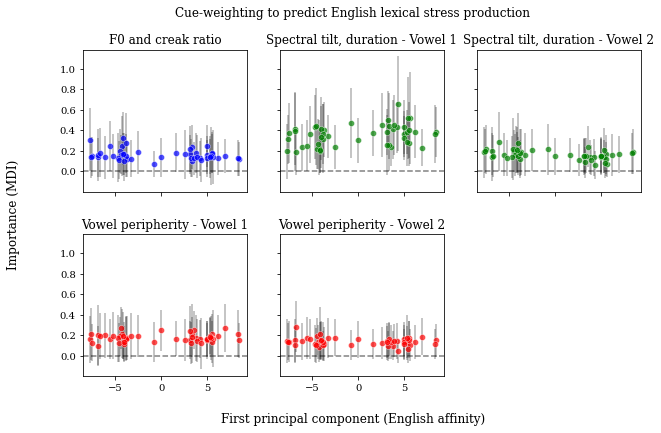

In [26]:
tex_fonts = {
    "font.family": "serif",
    # Use 10pt font in plots, to match 10pt font in document
    "axes.labelsize": 12,
    "font.size": 10,
    # Make the legend/label fonts a little smaller
    "legend.fontsize": 10,
    "xtick.labelsize": 10,
    "ytick.labelsize": 10
}
plt.rcParams.update(tex_fonts)

fig, axes = plt.subplots(2,3,
                         sharey = True, sharex = True, figsize = (10,6))
plt.subplots_adjust(hspace = 0.3)
sns.scatterplot(ax = axes[0,0], x = f0_creak.pc1,
                y = f0_creak['Importance (MDI)'], alpha = 0.7, color = "blue")

axes[0,0].errorbar(f0_creak.pc1, f0_creak['Importance (MDI)'],
                 yerr=f0_creak.Stdx2,
                 fmt=' ', zorder=-1, alpha = 0.3, color = "black")
axes[0,0].axhline(y = 0, color = "black", linestyle = "--", alpha = 0.5)
axes[0,0].set_title("F0 and creak ratio")

axes[0,1].axhline(y = 0, color = "black", linestyle = "--", alpha = 0.5)
axes[0,1].set_title("Spectral tilt, duration - Vowel 1")
axes[0,2].axhline(y = 0, color = "black", linestyle = "--", alpha = 0.5)
axes[0,2].set_title("Spectral tilt, duration - Vowel 2")
sns.scatterplot(ax = axes[0,1], x = spec_dur1.pc1,
                y = spec_dur1['Importance (MDI)'], alpha = 0.7, color = "green")
axes[0,1].errorbar(spec_dur1.pc1, spec_dur1['Importance (MDI)'],
                 yerr=spec_dur1.Stdx2,
                 fmt=' ', zorder=-1, alpha = 0.3, color = "black")

sns.scatterplot(ax = axes[0,2], x = spec_dur2.pc1,
                y = spec_dur2['Importance (MDI)'], alpha = 0.7, color = "green")
axes[0,2].errorbar(spec_dur2.pc1, spec_dur2['Importance (MDI)'],
                 yerr=spec_dur2.Stdx2,
                 fmt=' ', zorder=-1, alpha = 0.3, color = "black")

axes[1,0].axhline(y = 0, color = "black", linestyle = "--", alpha = 0.5)
axes[1,0].set_title("Vowel peripherity - Vowel 1")
axes[1,1].axhline(y = 0, color = "black", linestyle = "--", alpha = 0.5)
axes[1,1].set_title("Vowel peripherity - Vowel 2")
sns.scatterplot(ax = axes[1,0], x = vowel_periph1.pc1,
                y = vowel_periph1['Importance (MDI)'], alpha = 0.7, color = "red")
axes[1,0].errorbar(vowel_periph1.pc1, vowel_periph1['Importance (MDI)'],
                 yerr=vowel_periph1.Stdx2,
                 fmt=' ', zorder=-1, alpha = 0.3, color = "black")

sns.scatterplot(ax = axes[1,1], x = vowel_periph2.pc1,
                y = vowel_periph2['Importance (MDI)'], alpha = 0.7, color = "red")
axes[1,1].errorbar(vowel_periph2.pc1, vowel_periph2['Importance (MDI)'],
                 yerr=vowel_periph2.Stdx2,
                 fmt=' ', zorder=-1, alpha = 0.3, color = "black")

 
# axes[0,0].set_xticklabels(['', '', ''])
axes[0,0].set_xlabel("")
axes[0,1].set_xlabel("")
axes[0,2].set_xlabel("")
axes[1,0].set_xlabel("")
axes[1,1].set_xlabel("")

axes[0,0].set_ylabel("")
axes[0,1].set_ylabel("")
axes[0,2].set_ylabel("")
axes[1,0].set_ylabel("")
axes[1,1].set_ylabel("")
fig.supxlabel("First principal component (English affinity)")
fig.supylabel("Importance (MDI)")
fig.suptitle("Cue-weighting to predict English lexical stress production")
axes[1,2].remove()


# plt.ylim([-1.5,4.5])
# plt.savefig('figures/eng_importance_pc1.jpg', format='jpg', dpi = 800)
plt.show();

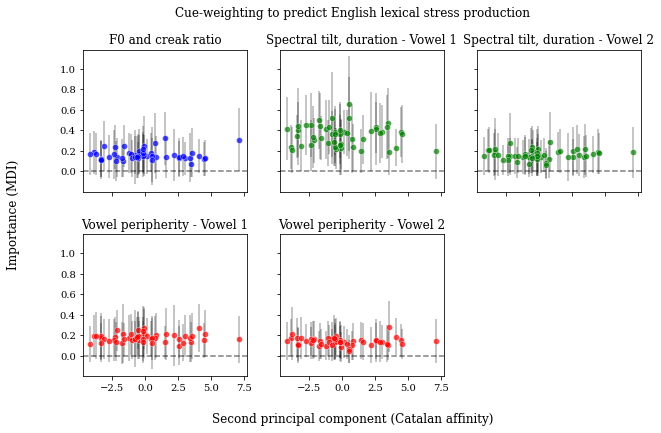

In [27]:
tex_fonts = {
    "font.family": "serif",
    # Use 10pt font in plots, to match 10pt font in document
    "axes.labelsize": 12,
    "font.size": 10,
    # Make the legend/label fonts a little smaller
    "legend.fontsize": 10,
    "xtick.labelsize": 10,
    "ytick.labelsize": 10
}
plt.rcParams.update(tex_fonts)

fig, axes = plt.subplots(2,3,
                         sharey = True, sharex = True, figsize = (10,6))
plt.subplots_adjust(hspace = 0.3)
sns.scatterplot(ax = axes[0,0], x = f0_creak.pc2,
                y = f0_creak['Importance (MDI)'], alpha = 0.7, color = "blue")

axes[0,0].errorbar(f0_creak.pc2, f0_creak['Importance (MDI)'],
                 yerr=f0_creak.Stdx2,
                 fmt=' ', zorder=-1, alpha = 0.3, color = "black")
axes[0,0].axhline(y = 0, color = "black", linestyle = "--", alpha = 0.5)
axes[0,0].set_title("F0 and creak ratio")

axes[0,1].axhline(y = 0, color = "black", linestyle = "--", alpha = 0.5)
axes[0,1].set_title("Spectral tilt, duration - Vowel 1")
axes[0,2].axhline(y = 0, color = "black", linestyle = "--", alpha = 0.5)
axes[0,2].set_title("Spectral tilt, duration - Vowel 2")
sns.scatterplot(ax = axes[0,1], x = spec_dur1.pc2,
                y = spec_dur1['Importance (MDI)'], alpha = 0.7, color = "green")
axes[0,1].errorbar(spec_dur1.pc2, spec_dur1['Importance (MDI)'],
                 yerr=spec_dur1.Stdx2,
                 fmt=' ', zorder=-1, alpha = 0.3, color = "black")

sns.scatterplot(ax = axes[0,2], x = spec_dur2.pc2,
                y = spec_dur2['Importance (MDI)'], alpha = 0.7, color = "green")
axes[0,2].errorbar(spec_dur2.pc2, spec_dur2['Importance (MDI)'],
                 yerr=spec_dur2.Stdx2,
                 fmt=' ', zorder=-1, alpha = 0.3, color = "black")

axes[1,0].axhline(y = 0, color = "black", linestyle = "--", alpha = 0.5)
axes[1,0].set_title("Vowel peripherity - Vowel 1")
axes[1,1].axhline(y = 0, color = "black", linestyle = "--", alpha = 0.5)
axes[1,1].set_title("Vowel peripherity - Vowel 2")
sns.scatterplot(ax = axes[1,0], x = vowel_periph1.pc2,
                y = vowel_periph1['Importance (MDI)'], alpha = 0.7, color = "red")
axes[1,0].errorbar(vowel_periph1.pc2, vowel_periph1['Importance (MDI)'],
                 yerr=vowel_periph1.Stdx2,
                 fmt=' ', zorder=-1, alpha = 0.3, color = "black")

sns.scatterplot(ax = axes[1,1], x = vowel_periph2.pc2,
                y = vowel_periph2['Importance (MDI)'], alpha = 0.7, color = "red")
axes[1,1].errorbar(vowel_periph2.pc2, vowel_periph2['Importance (MDI)'],
                 yerr=vowel_periph2.Stdx2,
                 fmt=' ', zorder=-1, alpha = 0.3, color = "black")

 
# axes[0,0].set_xticklabels(['', '', ''])
axes[0,0].set_xlabel("")
axes[0,1].set_xlabel("")
axes[0,2].set_xlabel("")
axes[1,0].set_xlabel("")
axes[1,1].set_xlabel("")

axes[0,0].set_ylabel("")
axes[0,1].set_ylabel("")
axes[0,2].set_ylabel("")
axes[1,0].set_ylabel("")
axes[1,1].set_ylabel("")
fig.supxlabel("Second principal component (Catalan affinity)")
fig.supylabel("Importance (MDI)")
fig.suptitle("Cue-weighting to predict English lexical stress production")
axes[1,2].remove()


# plt.ylim([-1.5,4.5])
# plt.savefig('figures/eng_importance_pc1.jpg', format='jpg', dpi = 800)
plt.show();

In [28]:
spa = df[df['Language']=="spa"].copy()
f0_creak = spa[spa['Feature']=="f0_creak_ratio"].copy()
vowel_periph1 = spa[spa['Feature']=="vowel_periph_vowel1"].copy()
vowel_periph2 = spa[spa['Feature']=="vowel_periph_vowel2"].copy()
spec_dur1 = spa[spa['Feature']=="spec_dur_vowel1"].copy()
spec_dur2 = spa[spa['Feature']=="spec_dur_vowel2"].copy()

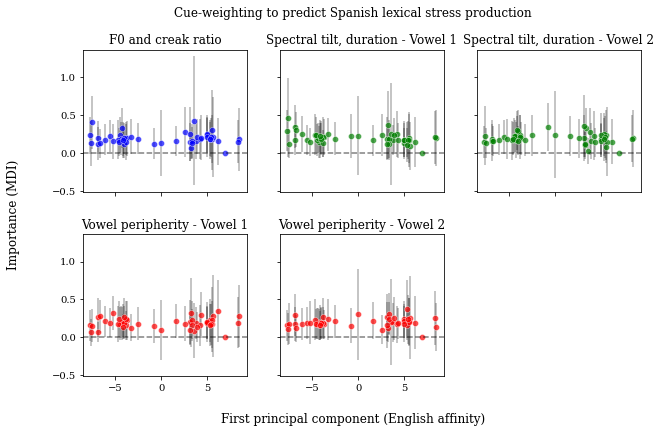

In [29]:
tex_fonts = {
    "font.family": "serif",
    # Use 10pt font in plots, to match 10pt font in document
    "axes.labelsize": 12,
    "font.size": 10,
    # Make the legend/label fonts a little smaller
    "legend.fontsize": 10,
    "xtick.labelsize": 10,
    "ytick.labelsize": 10
}
plt.rcParams.update(tex_fonts)

fig, axes = plt.subplots(2,3,
                         sharey = True, sharex = True, figsize = (10,6))
plt.subplots_adjust(hspace = 0.3)
sns.scatterplot(ax = axes[0,0], x = f0_creak.pc1,
                y = f0_creak['Importance (MDI)'], alpha = 0.7, color = "blue")

axes[0,0].errorbar(f0_creak.pc1, f0_creak['Importance (MDI)'],
                 yerr=f0_creak.Stdx2,
                 fmt=' ', zorder=-1, alpha = 0.3, color = "black")
axes[0,0].axhline(y = 0, color = "black", linestyle = "--", alpha = 0.5)
axes[0,0].set_title("F0 and creak ratio")

axes[0,1].axhline(y = 0, color = "black", linestyle = "--", alpha = 0.5)
axes[0,1].set_title("Spectral tilt, duration - Vowel 1")
axes[0,2].axhline(y = 0, color = "black", linestyle = "--", alpha = 0.5)
axes[0,2].set_title("Spectral tilt, duration - Vowel 2")
sns.scatterplot(ax = axes[0,1], x = spec_dur1.pc1,
                y = spec_dur1['Importance (MDI)'], alpha = 0.7, color = "green")
axes[0,1].errorbar(spec_dur1.pc1, spec_dur1['Importance (MDI)'],
                 yerr=spec_dur1.Stdx2,
                 fmt=' ', zorder=-1, alpha = 0.3, color = "black")

sns.scatterplot(ax = axes[0,2], x = spec_dur2.pc1,
                y = spec_dur2['Importance (MDI)'], alpha = 0.7, color = "green")
axes[0,2].errorbar(spec_dur2.pc1, spec_dur2['Importance (MDI)'],
                 yerr=spec_dur2.Stdx2,
                 fmt=' ', zorder=-1, alpha = 0.3, color = "black")

axes[1,0].axhline(y = 0, color = "black", linestyle = "--", alpha = 0.5)
axes[1,0].set_title("Vowel peripherity - Vowel 1")
axes[1,1].axhline(y = 0, color = "black", linestyle = "--", alpha = 0.5)
axes[1,1].set_title("Vowel peripherity - Vowel 2")
sns.scatterplot(ax = axes[1,0], x = vowel_periph1.pc1,
                y = vowel_periph1['Importance (MDI)'], alpha = 0.7, color = "red")
axes[1,0].errorbar(vowel_periph1.pc1, vowel_periph1['Importance (MDI)'],
                 yerr=vowel_periph1.Stdx2,
                 fmt=' ', zorder=-1, alpha = 0.3, color = "black")

sns.scatterplot(ax = axes[1,1], x = vowel_periph2.pc1,
                y = vowel_periph2['Importance (MDI)'], alpha = 0.7, color = "red")
axes[1,1].errorbar(vowel_periph2.pc1, vowel_periph2['Importance (MDI)'],
                 yerr=vowel_periph2.Stdx2,
                 fmt=' ', zorder=-1, alpha = 0.3, color = "black")

 
# axes[0,0].set_xticklabels(['', '', ''])
axes[0,0].set_xlabel("")
axes[0,1].set_xlabel("")
axes[0,2].set_xlabel("")
axes[1,0].set_xlabel("")
axes[1,1].set_xlabel("")

axes[0,0].set_ylabel("")
axes[0,1].set_ylabel("")
axes[0,2].set_ylabel("")
axes[1,0].set_ylabel("")
axes[1,1].set_ylabel("")
fig.supxlabel("First principal component (English affinity)")
fig.supylabel("Importance (MDI)")
fig.suptitle("Cue-weighting to predict Spanish lexical stress production")
axes[1,2].remove()


# plt.ylim([-1.5,4.5])
# plt.savefig('figures/eng_importance_pc1.jpg', format='jpg', dpi = 800)
plt.show();

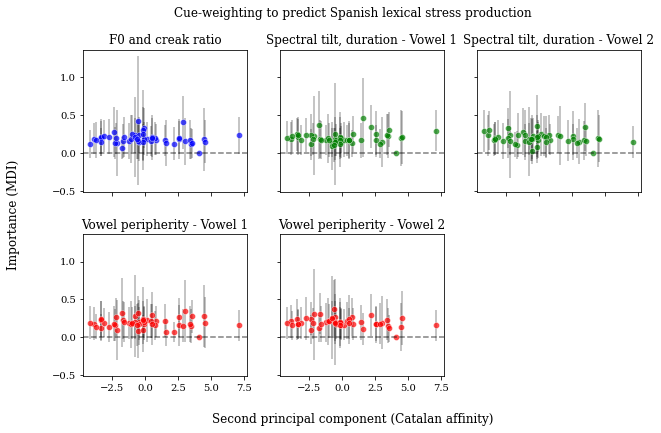

In [30]:
tex_fonts = {
    "font.family": "serif",
    # Use 10pt font in plots, to match 10pt font in document
    "axes.labelsize": 12,
    "font.size": 10,
    # Make the legend/label fonts a little smaller
    "legend.fontsize": 10,
    "xtick.labelsize": 10,
    "ytick.labelsize": 10
}
plt.rcParams.update(tex_fonts)

fig, axes = plt.subplots(2,3,
                         sharey = True, sharex = True, figsize = (10,6))
plt.subplots_adjust(hspace = 0.3)
sns.scatterplot(ax = axes[0,0], x = f0_creak.pc2,
                y = f0_creak['Importance (MDI)'], alpha = 0.7, color = "blue")

axes[0,0].errorbar(f0_creak.pc2, f0_creak['Importance (MDI)'],
                 yerr=f0_creak.Stdx2,
                 fmt=' ', zorder=-1, alpha = 0.3, color = "black")
axes[0,0].axhline(y = 0, color = "black", linestyle = "--", alpha = 0.5)
axes[0,0].set_title("F0 and creak ratio")

axes[0,1].axhline(y = 0, color = "black", linestyle = "--", alpha = 0.5)
axes[0,1].set_title("Spectral tilt, duration - Vowel 1")
axes[0,2].axhline(y = 0, color = "black", linestyle = "--", alpha = 0.5)
axes[0,2].set_title("Spectral tilt, duration - Vowel 2")
sns.scatterplot(ax = axes[0,1], x = spec_dur1.pc2,
                y = spec_dur1['Importance (MDI)'], alpha = 0.7, color = "green")
axes[0,1].errorbar(spec_dur1.pc2, spec_dur1['Importance (MDI)'],
                 yerr=spec_dur1.Stdx2,
                 fmt=' ', zorder=-1, alpha = 0.3, color = "black")

sns.scatterplot(ax = axes[0,2], x = spec_dur2.pc2,
                y = spec_dur2['Importance (MDI)'], alpha = 0.7, color = "green")
axes[0,2].errorbar(spec_dur2.pc2, spec_dur2['Importance (MDI)'],
                 yerr=spec_dur2.Stdx2,
                 fmt=' ', zorder=-1, alpha = 0.3, color = "black")

axes[1,0].axhline(y = 0, color = "black", linestyle = "--", alpha = 0.5)
axes[1,0].set_title("Vowel peripherity - Vowel 1")
axes[1,1].axhline(y = 0, color = "black", linestyle = "--", alpha = 0.5)
axes[1,1].set_title("Vowel peripherity - Vowel 2")
sns.scatterplot(ax = axes[1,0], x = vowel_periph1.pc2,
                y = vowel_periph1['Importance (MDI)'], alpha = 0.7, color = "red")
axes[1,0].errorbar(vowel_periph1.pc2, vowel_periph1['Importance (MDI)'],
                 yerr=vowel_periph1.Stdx2,
                 fmt=' ', zorder=-1, alpha = 0.3, color = "black")

sns.scatterplot(ax = axes[1,1], x = vowel_periph2.pc2,
                y = vowel_periph2['Importance (MDI)'], alpha = 0.7, color = "red")
axes[1,1].errorbar(vowel_periph2.pc2, vowel_periph2['Importance (MDI)'],
                 yerr=vowel_periph2.Stdx2,
                 fmt=' ', zorder=-1, alpha = 0.3, color = "black")

 
# axes[0,0].set_xticklabels(['', '', ''])
axes[0,0].set_xlabel("")
axes[0,1].set_xlabel("")
axes[0,2].set_xlabel("")
axes[1,0].set_xlabel("")
axes[1,1].set_xlabel("")

axes[0,0].set_ylabel("")
axes[0,1].set_ylabel("")
axes[0,2].set_ylabel("")
axes[1,0].set_ylabel("")
axes[1,1].set_ylabel("")
fig.supxlabel("Second principal component (Catalan affinity)")
fig.supylabel("Importance (MDI)")
fig.suptitle("Cue-weighting to predict Spanish lexical stress production")
axes[1,2].remove()


# plt.ylim([-1.5,4.5])
# plt.savefig('figures/eng_importance_pc1.jpg', format='jpg', dpi = 800)
plt.show();

In [31]:
cat = df[df['Language']=="cat"].copy()
f0_creak = cat[cat['Feature']=="f0_creak_ratio"].copy()
vowel_periph1 = cat[cat['Feature']=="vowel_periph_vowel1"].copy()
vowel_periph2 = cat[cat['Feature']=="vowel_periph_vowel2"].copy()
spec_dur1 = cat[cat['Feature']=="spec_dur_vowel1"].copy()
spec_dur2 = cat[cat['Feature']=="spec_dur_vowel2"].copy()

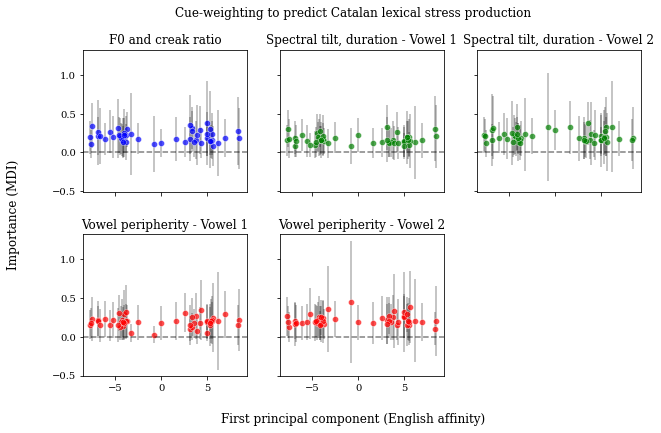

In [32]:
tex_fonts = {
    "font.family": "serif",
    # Use 10pt font in plots, to match 10pt font in document
    "axes.labelsize": 12,
    "font.size": 10,
    # Make the legend/label fonts a little smaller
    "legend.fontsize": 10,
    "xtick.labelsize": 10,
    "ytick.labelsize": 10
}
plt.rcParams.update(tex_fonts)

fig, axes = plt.subplots(2,3,
                         sharey = True, sharex = True, figsize = (10,6))
plt.subplots_adjust(hspace = 0.3)
sns.scatterplot(ax = axes[0,0], x = f0_creak.pc1,
                y = f0_creak['Importance (MDI)'], alpha = 0.7, color = "blue")

axes[0,0].errorbar(f0_creak.pc1, f0_creak['Importance (MDI)'],
                 yerr=f0_creak.Stdx2,
                 fmt=' ', zorder=-1, alpha = 0.3, color = "black")
axes[0,0].axhline(y = 0, color = "black", linestyle = "--", alpha = 0.5)
axes[0,0].set_title("F0 and creak ratio")

axes[0,1].axhline(y = 0, color = "black", linestyle = "--", alpha = 0.5)
axes[0,1].set_title("Spectral tilt, duration - Vowel 1")
axes[0,2].axhline(y = 0, color = "black", linestyle = "--", alpha = 0.5)
axes[0,2].set_title("Spectral tilt, duration - Vowel 2")
sns.scatterplot(ax = axes[0,1], x = spec_dur1.pc1,
                y = spec_dur1['Importance (MDI)'], alpha = 0.7, color = "green")
axes[0,1].errorbar(spec_dur1.pc1, spec_dur1['Importance (MDI)'],
                 yerr=spec_dur1.Stdx2,
                 fmt=' ', zorder=-1, alpha = 0.3, color = "black")

sns.scatterplot(ax = axes[0,2], x = spec_dur2.pc1,
                y = spec_dur2['Importance (MDI)'], alpha = 0.7, color = "green")
axes[0,2].errorbar(spec_dur2.pc1, spec_dur2['Importance (MDI)'],
                 yerr=spec_dur2.Stdx2,
                 fmt=' ', zorder=-1, alpha = 0.3, color = "black")

axes[1,0].axhline(y = 0, color = "black", linestyle = "--", alpha = 0.5)
axes[1,0].set_title("Vowel peripherity - Vowel 1")
axes[1,1].axhline(y = 0, color = "black", linestyle = "--", alpha = 0.5)
axes[1,1].set_title("Vowel peripherity - Vowel 2")
sns.scatterplot(ax = axes[1,0], x = vowel_periph1.pc1,
                y = vowel_periph1['Importance (MDI)'], alpha = 0.7, color = "red")
axes[1,0].errorbar(vowel_periph1.pc1, vowel_periph1['Importance (MDI)'],
                 yerr=vowel_periph1.Stdx2,
                 fmt=' ', zorder=-1, alpha = 0.3, color = "black")

sns.scatterplot(ax = axes[1,1], x = vowel_periph2.pc1,
                y = vowel_periph2['Importance (MDI)'], alpha = 0.7, color = "red")
axes[1,1].errorbar(vowel_periph2.pc1, vowel_periph2['Importance (MDI)'],
                 yerr=vowel_periph2.Stdx2,
                 fmt=' ', zorder=-1, alpha = 0.3, color = "black")

 
# axes[0,0].set_xticklabels(['', '', ''])
axes[0,0].set_xlabel("")
axes[0,1].set_xlabel("")
axes[0,2].set_xlabel("")
axes[1,0].set_xlabel("")
axes[1,1].set_xlabel("")

axes[0,0].set_ylabel("")
axes[0,1].set_ylabel("")
axes[0,2].set_ylabel("")
axes[1,0].set_ylabel("")
axes[1,1].set_ylabel("")
fig.supxlabel("First principal component (English affinity)")
fig.supylabel("Importance (MDI)")
fig.suptitle("Cue-weighting to predict Catalan lexical stress production")
axes[1,2].remove()


# plt.ylim([-1.5,4.5])
# plt.savefig('figures/eng_importance_pc1.jpg', format='jpg', dpi = 800)
plt.show();

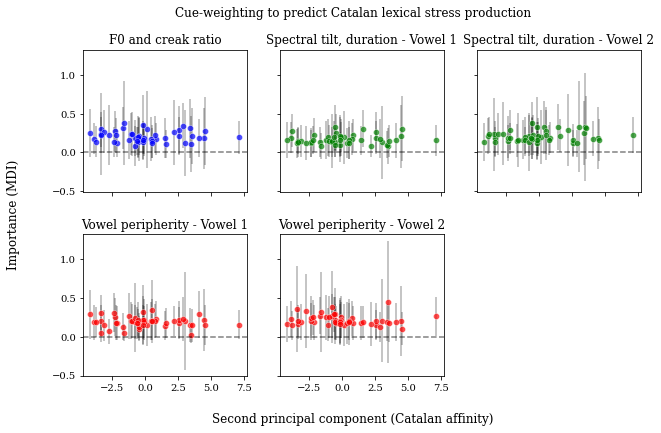

In [33]:
tex_fonts = {
    "font.family": "serif",
    # Use 10pt font in plots, to match 10pt font in document
    "axes.labelsize": 12,
    "font.size": 10,
    # Make the legend/label fonts a little smaller
    "legend.fontsize": 10,
    "xtick.labelsize": 10,
    "ytick.labelsize": 10
}
plt.rcParams.update(tex_fonts)

fig, axes = plt.subplots(2,3,
                         sharey = True, sharex = True, figsize = (10,6))
plt.subplots_adjust(hspace = 0.3)
sns.scatterplot(ax = axes[0,0], x = f0_creak.pc2,
                y = f0_creak['Importance (MDI)'], alpha = 0.7, color = "blue")

axes[0,0].errorbar(f0_creak.pc2, f0_creak['Importance (MDI)'],
                 yerr=f0_creak.Stdx2,
                 fmt=' ', zorder=-1, alpha = 0.3, color = "black")
axes[0,0].axhline(y = 0, color = "black", linestyle = "--", alpha = 0.5)
axes[0,0].set_title("F0 and creak ratio")

axes[0,1].axhline(y = 0, color = "black", linestyle = "--", alpha = 0.5)
axes[0,1].set_title("Spectral tilt, duration - Vowel 1")
axes[0,2].axhline(y = 0, color = "black", linestyle = "--", alpha = 0.5)
axes[0,2].set_title("Spectral tilt, duration - Vowel 2")
sns.scatterplot(ax = axes[0,1], x = spec_dur1.pc2,
                y = spec_dur1['Importance (MDI)'], alpha = 0.7, color = "green")
axes[0,1].errorbar(spec_dur1.pc2, spec_dur1['Importance (MDI)'],
                 yerr=spec_dur1.Stdx2,
                 fmt=' ', zorder=-1, alpha = 0.3, color = "black")

sns.scatterplot(ax = axes[0,2], x = spec_dur2.pc2,
                y = spec_dur2['Importance (MDI)'], alpha = 0.7, color = "green")
axes[0,2].errorbar(spec_dur2.pc2, spec_dur2['Importance (MDI)'],
                 yerr=spec_dur2.Stdx2,
                 fmt=' ', zorder=-1, alpha = 0.3, color = "black")

axes[1,0].axhline(y = 0, color = "black", linestyle = "--", alpha = 0.5)
axes[1,0].set_title("Vowel peripherity - Vowel 1")
axes[1,1].axhline(y = 0, color = "black", linestyle = "--", alpha = 0.5)
axes[1,1].set_title("Vowel peripherity - Vowel 2")
sns.scatterplot(ax = axes[1,0], x = vowel_periph1.pc2,
                y = vowel_periph1['Importance (MDI)'], alpha = 0.7, color = "red")
axes[1,0].errorbar(vowel_periph1.pc2, vowel_periph1['Importance (MDI)'],
                 yerr=vowel_periph1.Stdx2,
                 fmt=' ', zorder=-1, alpha = 0.3, color = "black")

sns.scatterplot(ax = axes[1,1], x = vowel_periph2.pc2,
                y = vowel_periph2['Importance (MDI)'], alpha = 0.7, color = "red")
axes[1,1].errorbar(vowel_periph2.pc2, vowel_periph2['Importance (MDI)'],
                 yerr=vowel_periph2.Stdx2,
                 fmt=' ', zorder=-1, alpha = 0.3, color = "black")

 
# axes[0,0].set_xticklabels(['', '', ''])
axes[0,0].set_xlabel("")
axes[0,1].set_xlabel("")
axes[0,2].set_xlabel("")
axes[1,0].set_xlabel("")
axes[1,1].set_xlabel("")

axes[0,0].set_ylabel("")
axes[0,1].set_ylabel("")
axes[0,2].set_ylabel("")
axes[1,0].set_ylabel("")
axes[1,1].set_ylabel("")
fig.supxlabel("Second principal component (Catalan affinity)")
fig.supylabel("Importance (MDI)")
fig.suptitle("Cue-weighting to predict Catalan lexical stress production")
axes[1,2].remove()


# plt.ylim([-1.5,4.5])
# plt.savefig('figures/eng_importance_pc1.jpg', format='jpg', dpi = 800)
plt.show();

## Get visualization across language profile in English

In [34]:
df_wd.columns

Index(['spec_dur_vowel1', 'vowel_periph_vowel1', 'partID', 'Language',
       'spec_dur_vowel2', 'vowel_periph_vowel2', 'stress_wd',
       'f0_creak_ratio'],
      dtype='object')

In [35]:
df_wd_lang = pd.merge(df_wd, parts, on = "partID", how = "left")
df_wd_lang.head()

,spec_dur_vowel1,vowel_periph_vowel1,partID,Language,spec_dur_vowel2,vowel_periph_vowel2,stress_wd,f0_creak_ratio,lang_profile
0,-2.082444,-0.034866,afs116,cat,4.574169,0.112931,Oxytone,0.586621,l1_eng
1,3.266917,1.798889,afs116,cat,5.502514,0.004191,Oxytone,0.885033,l1_eng
2,4.762114,1.791195,afs116,cat,5.561161,0.379749,Oxytone,0.851287,l1_eng
3,5.082870,1.946327,afs116,cat,5.520534,0.375616,Oxytone,0.889843,l1_eng
4,3.738210,1.443353,afs116,cat,5.946262,0.403462,Oxytone,1.101281,l1_eng


In [36]:
eng_lang = df_wd_lang[df_wd_lang['Language']=="eng"].copy()

In [37]:
y_eng = eng_lang['stress_wd']
X_eng = eng_lang.drop(['stress_wd', 'Language', 'partID', 'lang_profile'], axis = 1)
    
rf_classifier = RandomForestClassifier(random_state = 10)
    
param_grid = { 
    'n_estimators': [500],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : np.arange(4,10,1),
    'criterion' :['gini', 'entropy']
}

CV_rfc_eng = GridSearchCV(estimator=rf_classifier, param_grid=param_grid, cv= 5)
CV_rfc_eng.fit(X_eng, y_eng)
    
print("Best RF Estimator: ", CV_rfc_eng.best_params_, "\n")
    
scores_eng = cross_val_score(rf_classifier, X_eng, y_eng.ravel(), cv=5)
print("Accuracy over all data: ", scores_eng.mean())
    
rf_classifier_best_eng = CV_rfc_eng.best_estimator_

cols_eng = X_eng.columns

Best RF Estimator:  {'criterion': 'gini', 'max_depth': 9, 'max_features': 'auto', 'n_estimators': 500} 

Accuracy over all data:  0.7675162790697675


In [38]:
def rf_eng_lang(df, rf_classifier_best, cols):
    lang_profile = []
    stats_list = []
        
    for l in df.lang_profile.unique():
        data = df[df['lang_profile']==l].copy()
        data.drop(['Language', 'partID', 'lang_profile'], axis = 1, inplace = True)
            
        # define predictor label
        y = data['stress_wd']

        # define feature set
        X = data.drop(['stress_wd'], axis = 1)
            
        rf_classifier_best.fit(X, y.ravel())
        stats = cbook.boxplot_stats(np.vstack([tree.feature_importances_ for tree in rf_classifier_best.estimators_]),
                    labels=cols, bootstrap=10000)
        
        stats_list.append(stats)
        lang_profile.append(l)
        
    return(lang_profile, stats_list)

In [39]:
lang_profile_list, stats_list = rf_eng_lang(eng_lang, rf_classifier_best_eng, cols_eng)

In [40]:
lang_profile_list

['l1_eng', 'l3_eng', 'mono']

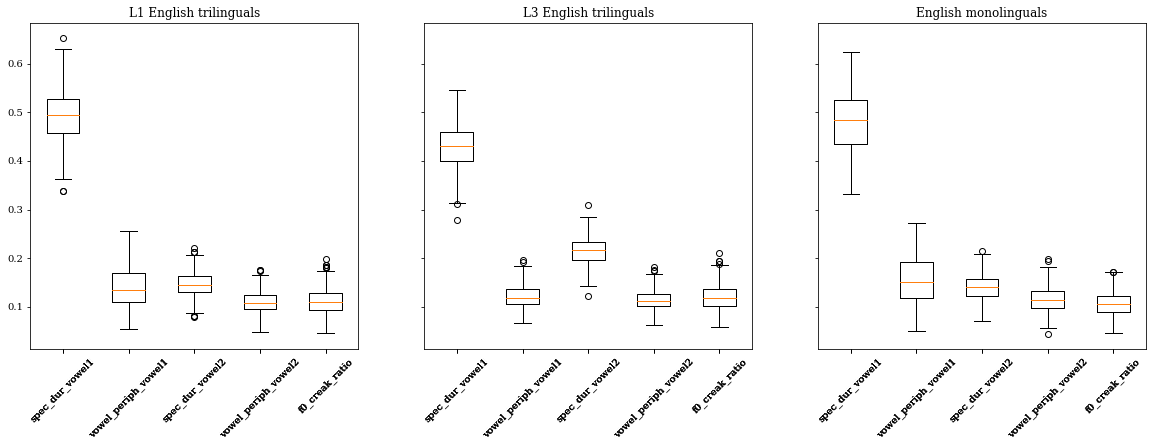

<Figure size 432x288 with 0 Axes>

In [51]:
fig, ax = plt.subplots(1, 3, figsize = (20,6), sharey = True, sharex = True)
ax[0].bxp(stats_list[0])
ax[1].bxp(stats_list[1])
ax[2].bxp(stats_list[2])

ax[0].set_title("L1 English trilinguals")
ax[1].set_title("L3 English trilinguals")
ax[2].set_title("English monolinguals")
ax[0].tick_params(axis='x', rotation=45)
ax[1].tick_params(axis='x', rotation=45)
ax[2].tick_params(axis='x', rotation=45)
# ax.set_title("Feature importances for L1 English trilinguals")
# ax.set_ylabel("Decrease in impurity")
# ax.set_ylim(-0.05,1)
plt.figure();